In [6]:
import requests
import pandas as pd

# Replace these variables with your specific parameters
base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
parameters = {
    "parameters": "ALLSKY_SFC_SW_DWN",
    "start": "20240707",
    "end": "20240713",
    "latitude": 30.9529,
    "longitude": -103.3617,
    "format": "JSON",
    "community": "re",
}

# Step 1: Fetch data from NASA POWER API
response = requests.get(base_url, params=parameters)
data = response.json()

# Step 2: Parse the data
timestamps = list(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"].keys())
irradiance_values = list(data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"].values())

# Step 3: Create a DataFrame
solar_data = {
    "Datetime": pd.to_datetime(timestamps, format="%Y%m%d%H"),  # Convert strings to datetime
    "Solar_Irradiance": irradiance_values,
}
solar_df = pd.DataFrame(solar_data)

# Step 4: Calculate Availability
solar_df["Availability"] = solar_df["Solar_Irradiance"] / max(solar_df["Solar_Irradiance"])

# Step 5: Configure display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 6: Display the DataFrame
print(solar_df)

# Step 7: (Optional) Save to a CSV file
solar_df.to_csv("solar_data_final.csv", index=False)


/Users/skyegoodman/Documents/OPTIMISING POWER GRIDS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


               Datetime  Solar_Irradiance  Availability
0   2024-07-07 00:00:00              0.00      0.000000
1   2024-07-07 01:00:00              0.00      0.000000
2   2024-07-07 02:00:00              0.00      0.000000
3   2024-07-07 03:00:00              0.00      0.000000
4   2024-07-07 04:00:00              0.00      0.000000
5   2024-07-07 05:00:00             52.53      0.051933
6   2024-07-07 06:00:00            247.25      0.244439
7   2024-07-07 07:00:00            460.20      0.454968
8   2024-07-07 08:00:00            665.08      0.657519
9   2024-07-07 09:00:00            841.60      0.832032
10  2024-07-07 10:00:00            965.15      0.954177
11  2024-07-07 11:00:00            999.65      0.988285
12  2024-07-07 12:00:00            935.35      0.924716
13  2024-07-07 13:00:00            724.05      0.715818
14  2024-07-07 14:00:00            731.17      0.722857
15  2024-07-07 15:00:00            516.12      0.510252
16  2024-07-07 16:00:00            376.50      0

Ramp rates (MW/hour): {3: array([14.99991163]), 4: array([9.99938364]), 5: array([50.00747873])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 24 01:35:12 PM: Your problem has 840 variables, 101130 constraints, and 0 parameters.
(CVXPY) Jan 24 01:35:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 01:35:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 01:35:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 01:35:12 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------

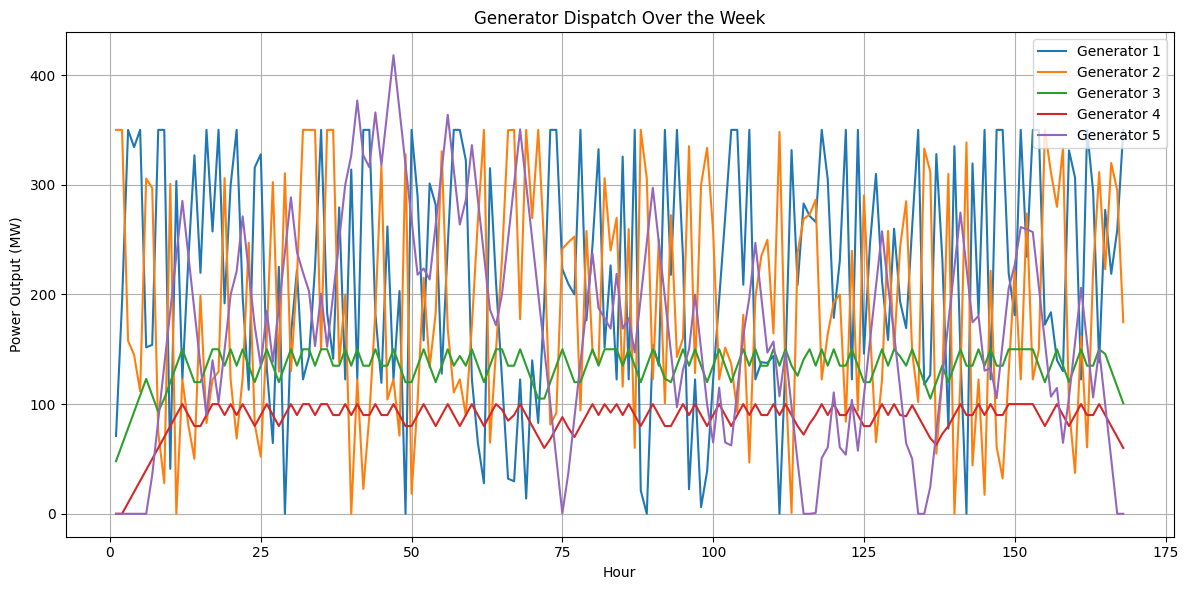

In [11]:
# SOLVER WITH WIND, SOLAR AND RAMPING CONSTRAINTS
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)  # 168 hours by 20 demand nodes
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)  # PTDF matrix
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)  # Line ratings
# -------------------------------------------------------------------------------------------------------

# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SOLVE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    """
    Simulates a generator's ramping response using a delay differential equation (DDE).
    Args:
        tau: Time constant for the generator.
        delay: Time delay before response begins.
        P_initial: Initial power output (MW).
        P_target: Target power output (MW).
        duration: Total simulation time (hours).
        steps: Number of time steps for simulation.
    Returns:
        ramp_rate: Approximate ramp rate (MW/hour).
    """
    time = np.linspace(0, duration, steps)

    # Define the DDE model
    def model(P, t):
        return (P_target - P(t - delay)) / tau

    # Define the history function
    def history(t):
        return P_initial

    # Solve the DDE
    response = ddeint(model, history, time)

    # Approximate ramp rate as the slope over the simulation period
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)  # Return the absolute value of ramp rate

# Determine ramp rates for generators 3, 4, and 5
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND CONTRIBUTIONS AS MATRICES
# Generator contributions
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# # HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
# # Load solar irradiance data (output from NASA POWER API processing)
# solar_data = pd.read_csv("solar_data_final.csv")
# solar_availability = solar_data["Availability"].values  # Use raw availability values from the data

# # Generate Weibull-distributed wind availability
# hours = node_demands.shape[0]
# shape, scale = 2.0, 0.8  # Example Weibull parameters
# wind_availability = np.random.weibull(shape, hours) * scale
# wind_availability = np.clip(wind_availability, 0.4, 1.0)  # Ensure at least 40% availability

# # Create the availability matrix
# availability_matrix = np.ones((len(gen_IDs), hours))
# availability_matrix[1, :] = solar_availability  # Generator 1 (wind)
# availability_matrix[0, :] = wind_availability  # Generator 2 (solar)

# # -------------------------------------------------------------------------------------------------------
# # CALCULATE EFFECTIVE CAPACITY FOR DEBUGGING
# effective_capacity = gen_capacities[:, None] * availability_matrix
# print("Effective Capacity (Generator 1):", effective_capacity[0])
# print("Effective Capacity (Generator 2):", effective_capacity[1])

# # -------------------------------------------------------------------------------------------------------
# # DECISION VARIABLES: q_supply - power supply from each generator for each hour (5x168)
# q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# # OBJECTIVE FUNCTION - minimise total dispatch costs
# objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# # -------------------------------------------------------------------------------------------------------
# # CONSTRAINTS
# constraints = []

# # (1) - Total hourly generation must equal the total hourly demand
# constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# (2) - Line flow constraints
# net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
# PF = shift_factor_matrix.values @ net_injections

# finite_mask = np.isfinite(line_ratings.values.flatten())
# constraints += [
#     PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
#     PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
# ]

# # (3) - Generator capacity constraints with hourly availability
# constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# # (4) - Ensure remaining demand is met by Generators 3, 4, and 5
# remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
# constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# # (5) - Capacity constraints for Generators 3, 4, and 5
# constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# # # (6) - Ramping constraints for Generators 3, 4, and 5
# # for t in range(1, hours):
# #     for g, ramp_rate in ramp_rates.items():
# #         gen_idx = g - 1  # Adjust for zero-based indexing
# #         constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
# #         constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# # -------------------------------------------------------------------------------------------------------
# # SOLVE THE OPTIMISATION PROBLEM
# problem = cp.Problem(objective, constraints)
# problem.solve(verbose=True, solver=cp.CBC)

# # -------------------------------------------------------------------------------------------------------
# # RESULTS
# if problem.status == cp.OPTIMAL:
#     print("OPTIMAL SOLUTION FOUND!")
#     print(f"Dispatch costs (£): {problem.value:.2f}")
# else:
#     print("NO OPTIMAL SOLUTION FOUND!")

# # Convert optimal generator dispatch to a pandas DataFrame for better readability
# q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
# print("Optimal generator dispatch (MW):")
# print(q_supply_table)

# # -------------------------------------------------------------------------------------------------------
# # PLOT THE DISPATCH FROM GENERATORS OVER THE WEEK
# plt.figure(figsize=(12, 6))
# for g in range(len(gen_IDs)):
#     plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
# plt.xlabel("Hour")
# plt.ylabel("Power Output (MW)")
# plt.title("Generator Dispatch Over the Week")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# HOURLY AVAILABILITY FOR GENERATORS 1 AND 2
# Generate Weibull-distributed wind availability for both generators
hours = node_demands.shape[0]
shape, scale = 2.0, 0.8  # Example Weibull parameters for wind distribution
wind_availability_1 = np.random.weibull(shape, hours) * scale
wind_availability_2 = np.random.weibull(shape, hours) * scale

# Enforce minimum availability of 0.6
wind_availability_1 = np.clip(wind_availability_1, 0.35, 1.0)
wind_availability_2 = np.clip(wind_availability_2, 0.35, 1.0)

# Create the availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_1  # Generator 1 (wind)
availability_matrix[1, :] = wind_availability_2  # Generator 2 (wind)

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES: q_supply - power supply from each generator for each hour (5x168)
q_supply = cp.Variable((len(gen_IDs), len(node_demands)), nonneg=True)  # (MW)

# OBJECTIVE FUNCTION - minimise total dispatch costs
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# (1) - Total hourly generation must equal the total hourly demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# (2) - Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections

finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# (3) - Generator capacity constraints with hourly availability
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# (4) - Ensure remaining demand is met by Generators 3, 4, and 5
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# (5) - Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# (6) - Ramping constraints for Generators 3, 4, and 5
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1  # Adjust for zero-based indexing
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a pandas DataFrame for better readability
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT THE DISPATCH FROM GENERATORS OVER THE WEEK
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
print("Availability Matrix:")
print(availability_matrix)

Availability Matrix:
[[0.         0.         0.         0.         0.         0.05193277
  0.24443895 0.45496787 0.65751854 0.83203164 0.95417696 0.98828473
  0.92471577 0.71581809 0.72285714 0.5102521  0.37221948 0.20471577
  0.03794365 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04391498
  0.22251112 0.41193277 0.55541275 0.63017301 0.65394958 0.70074147
  0.64639644 0.62160158 0.71209095 0.58024716 0.40906574 0.20685121
  0.02706871 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.0405042
  0.22542758 0.43921898 0.63450321 0.80441918 0.90044488 0.86895699
  0.83010381 0.79649036 0.6788433  0.5228868  0.38233317 0.23064755
  0.0397133  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04854177
  0.2402175  0.45684627 0.65983193 0.82778052 0.94516065 0.97792388
  0.95709343 0.88584281 0.76930302 0.57076619 0.3782

In [13]:
# Debugging Effective Capacity and Remaining Demand
effective_capacity = gen_capacities[:, None] * availability_matrix
print("Effective Capacity (Generator 1):", effective_capacity[0])
print("Effective Capacity (Generator 2):", effective_capacity[1])

# Remaining Demand
remaining_demand_values = (
    np.sum(node_demands.values.T, axis=0)
    - (np.sum(q_supply[:2, :].value, axis=0) if q_supply.value is not None else np.zeros(hours))
)
print("Remaining Demand (per hour):", remaining_demand_values)

# Check Total Supply vs. Demand
total_available_capacity = np.sum(effective_capacity, axis=0)
total_demand = np.sum(node_demands.values.T, axis=0)
print("Total Available Capacity (per hour):", total_available_capacity)
print("Total Demand (per hour):", total_demand)

Effective Capacity (Generator 1): [  0.           0.           0.           0.           0.
  18.17647059  85.55363322 159.23875433 230.13148789 291.21107266
 333.96193772 345.89965398 323.65051903 250.53633218 253.
 178.58823529 130.27681661  71.65051903  13.28027682   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.37024221
  77.87889273 144.17647059 194.39446367 220.56055363 228.88235294
 245.25951557 226.23875433 217.56055363 249.23183391 203.08650519
 143.17301038  72.39792388   9.47404844   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          14.17647059  78.89965398
 153.7266436  222.07612457 281.5467128  315.15570934 304.1349481
 290.53633218 278.7716263  237.59515571 183.01038062 133.816609
  80.7266436   13.89965398   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          16.98961938  84

In [14]:
total_demand = np.sum(node_demands.values.T, axis=0)  # Sum across nodes for each hour
total_available_capacity = np.sum(effective_capacity, axis=0)  # Total available capacity each hour

print("Hour | Total Demand | Total Available Capacity")
for hour in range(len(total_demand)):
    print(f"{hour+1:4} | {total_demand[hour]:12.2f} | {total_available_capacity[hour]:25.2f}")

Hour | Total Demand | Total Available Capacity
   1 |       468.93 |                   1100.00
   2 |       605.96 |                    890.00
   3 |       595.61 |                    890.00
   4 |       592.07 |                    890.00
   5 |       599.63 |                   1031.99
   6 |       620.28 |                    988.54
   7 |       644.29 |                   1110.36
   8 |       662.50 |                   1117.97
   9 |       688.22 |                   1170.82
  10 |       726.99 |                   1313.95
  11 |       763.65 |                   1433.96
  12 |       780.28 |                   1445.90
  13 |       773.56 |                   1423.65
  14 |       762.20 |                   1186.63
  15 |       753.62 |                   1143.00
  16 |       747.67 |                   1218.00
  17 |       769.87 |                   1020.28
  18 |       830.97 |                   1171.65
  19 |       872.48 |                   1113.28
  20 |       871.62 |                   1

In [15]:
print("Hour | Effective Capacity (Solar) | Dispatch (Solar)")
for hour in range(availability_matrix.shape[1]):
    print(f"{hour+1:4} | {effective_capacity[0, hour]:25.2f} | {q_supply.value[0, hour]:10.2f}")

Hour | Effective Capacity (Solar) | Dispatch (Solar)


TypeError: 'NoneType' object is not subscriptable

Ramp rates (MW/hour): {3: array([14.99991163]), 4: array([9.99938364]), 5: array([50.00747873])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 24 03:26:53 PM: Your problem has 840 variables, 101130 constraints, and 0 parameters.
(CVXPY) Jan 24 03:26:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 03:26:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 03:26:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 03:26:53 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------

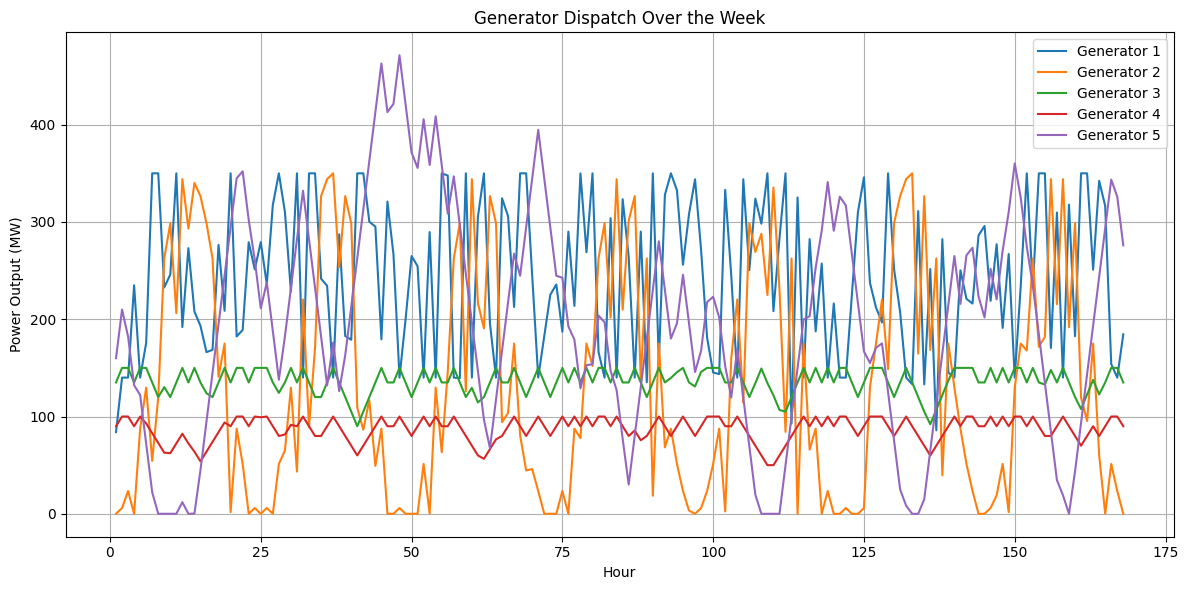

In [7]:
# GEN 1: WIND 
# GEN 2:SOLAR 
# GEN 3, 4, 5: COAL N GAS
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# SOLAR AND WIND AVAILABILITY
hours = node_demands.shape[0]
time = np.arange(hours)

# Solar availability as a sine wave (Generator 2)
solar_availability = 0.5 * (1 + np.sin(2 * np.pi * time / 24 - np.pi / 2))  # Sine wave shifted to make nighttime 0
solar_availability = np.clip(solar_availability, 0, 1)  # Ensure values are between 0 and 1

# Wind availability as a Weibull distribution (Generator 1)
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability = np.random.weibull(shape, hours) * scale
wind_availability = np.clip(wind_availability, 0.4, 1.0)  # Ensure at least 40% availability

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability  # Wind generator (Generator 1)
availability_matrix[1, :] = solar_availability  # Solar generator (Generator 2)

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# Ramping constraints
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ramp rates (MW/hour): {3: array([14.99991163]), 4: array([9.99938364]), 5: array([50.00747873])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 24 06:18:01 PM: Your problem has 840 variables, 101130 constraints, and 0 parameters.
(CVXPY) Jan 24 06:18:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 06:18:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 06:18:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 06:18:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------

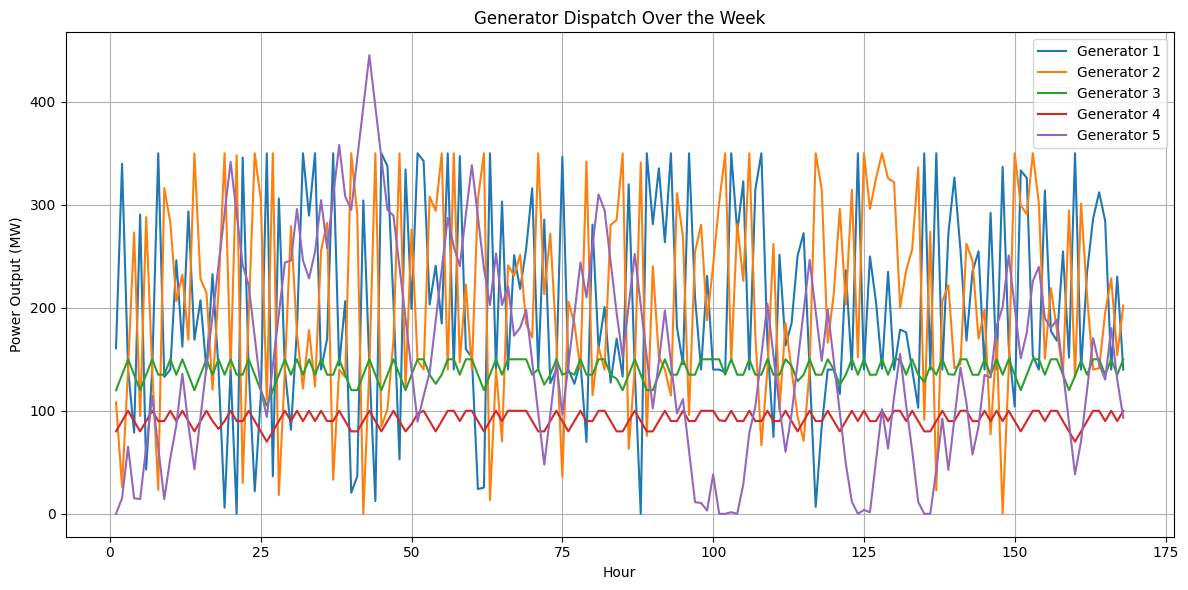

In [13]:
# -------------------------------------------------------------------------------------------------------
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# EXTRACT REQUIRED INFO FROM INPUT DATA
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

demand_IDs = np.array(node_demands.columns.astype(int))
node_IDs = np.array(shift_factor_matrix.columns.astype(int))

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [3, 4, 5], [1.5, 2.0, 2.5], [0.5, 0.7, 1.0], [0, 0, 0], [gen_capacities[2], gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
gen_indices = {g_ID: np.where(node_IDs == g_ID)[0][0] for g_ID in gen_IDs}
gen_identity_mat = np.zeros((len(node_IDs), len(gen_IDs)))
gen_identity_mat[list(gen_indices.values()), np.arange(len(gen_IDs))] = 1

demand_indices = {d_ID: np.where(node_IDs == d_ID)[0][0] for d_ID in demand_IDs}
demand_identity_mat = np.zeros((len(node_IDs), len(demand_IDs)))
demand_identity_mat[list(demand_indices.values()), np.arange(len(demand_IDs))] = 1

# -------------------------------------------------------------------------------------------------------
# WIND AVAILABILITY FOR GENERATORS 1 AND 2
hours = node_demands.shape[0]

# Wind availability for both Generator 1 and Generator 2 using Weibull distribution
shape, scale = 2.0, 0.8  # Example Weibull parameters
wind_availability_gen1 = np.random.weibull(shape, hours) * scale
wind_availability_gen2 = np.random.weibull(shape, hours) * scale

# Clip wind availability to ensure it's between 40% and 100% availability
wind_availability_gen1 = np.clip(wind_availability_gen1, 0.4, 1.0)
wind_availability_gen2 = np.clip(wind_availability_gen2, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1  # Wind generator (Generator 1)
availability_matrix[1, :] = wind_availability_gen2  # Wind generator (Generator 2)

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:2, :], axis=0)
constraints.append(cp.sum(q_supply[2:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 3, 4, and 5
constraints += [q_supply[2:, :] <= gen_capacities[2:, None]]

# Ramping constraints
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Updated Generator Data:
              MC  CAP    NODE
GENERATOR_1    0  350   23914
GENERATOR_2    0  350   23912
GENERATOR_3    0  350  141609
GENERATOR_4  100  100  142562
GENERATOR_5  500  500   23920
Ramp rates (MW/hour): {4: array([9.99938364]), 5: array([50.00747873])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 24 06:22:24 PM: Your problem has 840 variables, 100628 constraints, and 0 parameters.
(CVXPY) Jan 24 06:22:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 06:22:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 06:22:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 06:22:24 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------

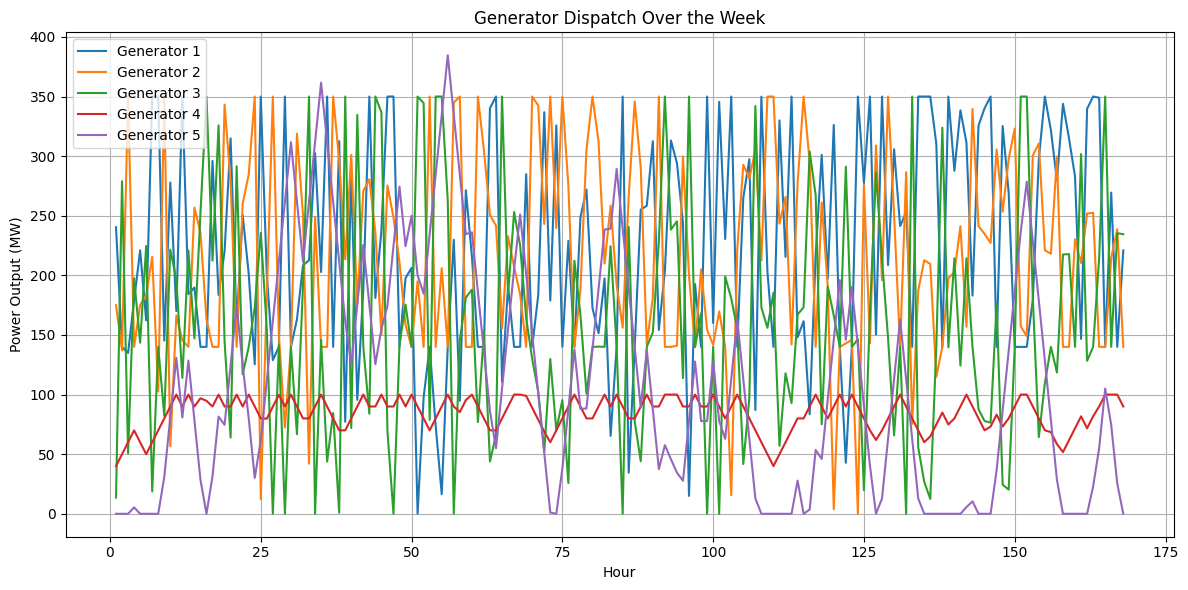

In [14]:
# -------------------------------------------------------------------------------------------------------
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# -------------------------------------------------------------------------------------------------------
# MODIFY GENERATOR 3 PROPERTIES
generator_data.loc["GENERATOR_3", "MC"] = 0  # Set marginal cost to 0
generator_data.loc["GENERATOR_3", "CAP"] = 350  # Set capacity to 350 MW

# Extract updated info
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

# Display updated generator data
print("Updated Generator Data:")
print(generator_data)

# -------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [4, 5], [2.0, 2.5], [0.7, 1.0], [0, 0], [gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
# Ensure consistent data types between gen_IDs and shift_factor_matrix.columns
node_demands.columns = node_demands.columns.astype(int)
shift_factor_matrix.columns = shift_factor_matrix.columns.astype(int)

# Map generator IDs to their indices in the shift factor matrix
gen_indices = {}
for g_ID in gen_IDs:
    matches = np.where(shift_factor_matrix.columns == g_ID)[0]
    if matches.size > 0:
        gen_indices[g_ID] = matches[0]
    else:
        print(f"Warning: Generator ID {g_ID} not found in shift_factor_matrix.columns.")
        gen_indices[g_ID] = None

# Initialize the generator identity matrix
gen_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(gen_IDs)))

# Safely populate gen_identity_mat, skipping any unmatched IDs
for g_ID, idx in gen_indices.items():
    if idx is not None:
        gen_identity_mat[idx, np.where(gen_IDs == g_ID)[0][0]] = 1

# Map demand IDs to their indices in the shift factor matrix
demand_indices = {}
for d_ID in node_demands.columns:
    matches = np.where(shift_factor_matrix.columns == d_ID)[0]
    if matches.size > 0:
        demand_indices[d_ID] = matches[0]
    else:
        print(f"Warning: Demand ID {d_ID} not found in shift_factor_matrix.columns.")
        demand_indices[d_ID] = None

# Initialize the demand identity matrix
demand_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(node_demands.columns)))

# Safely populate demand_identity_mat, skipping unmatched IDs
for d_ID, idx in demand_indices.items():
    if idx is not None:
        demand_identity_mat[idx, np.where(node_demands.columns == d_ID)[0][0]] = 1

# -------------------------------------------------------------------------------------------------------
# WIND AVAILABILITY
hours = node_demands.shape[0]

# Weibull-distributed wind availability for Generators 1, 2, and 3
shape, scale = 2.0, 0.8
wind_availability_gen1 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen2 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen3 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1  # Wind generator 1
availability_matrix[1, :] = wind_availability_gen2  # Wind generator 2
availability_matrix[2, :] = wind_availability_gen3  # Wind generator 3

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation must meet demand
constraints.append(cp.sum(q_supply, axis=0) == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:3, :], axis=0)
constraints.append(cp.sum(q_supply[3:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 4 and 5
constraints += [q_supply[3:, :] <= gen_capacities[3:, None]]

# Ramping constraints for Generators 4 and 5
for t in range(1, hours):
    for g, ramp_rate in ramp_rates.items():
        gen_idx = g - 1  # Adjust for zero-based indexing
        constraints.append(q_supply[gen_idx, t] - q_supply[gen_idx, t - 1] <= ramp_rate)
        constraints.append(q_supply[gen_idx, t - 1] - q_supply[gen_idx, t] <= ramp_rate)

# -------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# -------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# -------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch to a DataFrame
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Updated Generator Data:
              MC  CAP    NODE
GENERATOR_1    0  350   23914
GENERATOR_2    0  350   23912
GENERATOR_3    0  350  141609
GENERATOR_4  100  100  142562
GENERATOR_5  500  500   23920
Ramp rates (MW/hour): {4: array([9.99938364]), 5: array([50.00747873])}
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 24 06:32:59 PM: Your problem has 1344 variables, 100632 constraints, and 0 parameters.
(CVXPY) Jan 24 06:32:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 24 06:32:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 24 06:32:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 24 06:32:59 PM: Your problem is compiled with the CPP canonicalization backend.
-----------------------------

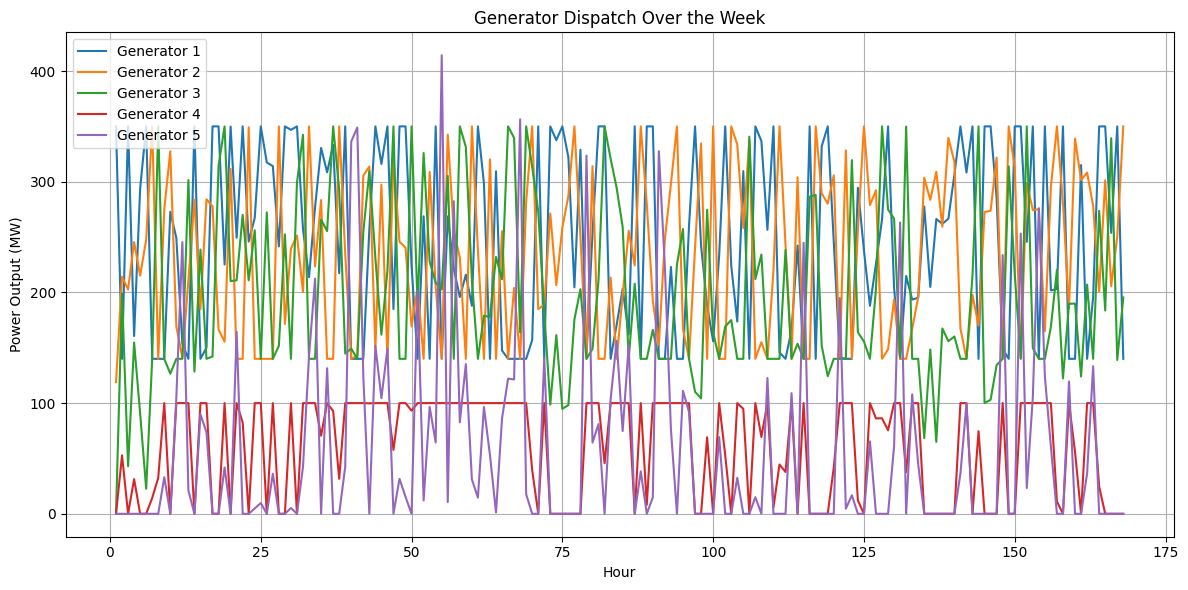

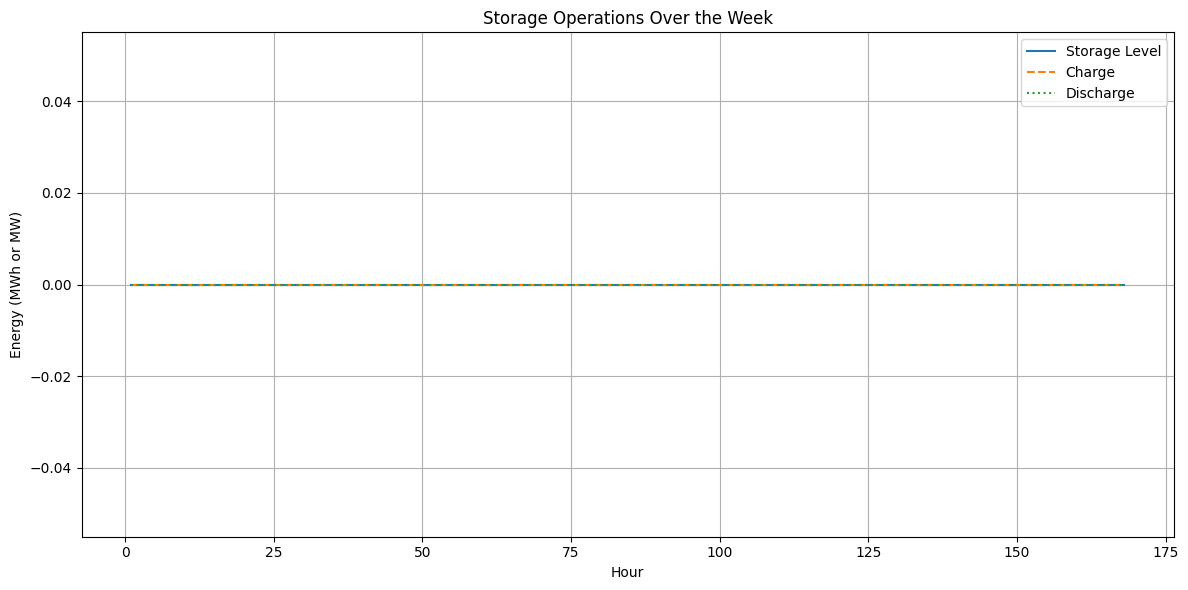

In [16]:
# ---------------------------------------------------------------------------------------------------------
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import cvxpy as cp
from ddeint import ddeint
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------------------------------------
# INPUT DATA
generator_data = pd.read_csv("provided_material/generators.csv", index_col=0)
node_demands = pd.read_csv("provided_material/hourlydemandbynode.csv", index_col=0)
shift_factor_matrix = pd.read_csv("provided_material/shiftfactormatrix.csv", index_col=0)
line_ratings = pd.read_csv("provided_material/lineratings.csv", index_col=0)

# ---------------------------------------------------------------------------------------------------------
# MODIFY GENERATOR 3 PROPERTIES
generator_data.loc["GENERATOR_3", "MC"] = 0  # Set marginal cost to 0
generator_data.loc["GENERATOR_3", "CAP"] = 350  # Set capacity to 350 MW

# Extract updated info
gen_IDs = np.array(generator_data.loc[:, "NODE"].astype(int))
gen_marginal_costs = np.array(generator_data.loc[:, "MC"])  # (£/MWh)
gen_capacities = np.array(generator_data.loc[:, "CAP"])  # (MW)

# Display updated generator data
print("Updated Generator Data:")
print(generator_data)

# ---------------------------------------------------------------------------------------------------------
# FUNCTION TO SIMULATE DDE AND DETERMINE RAMP RATES
def simulate_dde(tau, delay, P_initial, P_target, duration=10, steps=1000):
    time = np.linspace(0, duration, steps)

    def model(P, t):
        return (P_target - P(t - delay)) / tau

    def history(t):
        return P_initial

    response = ddeint(model, history, time)
    ramp_rate = (response[-1] - response[0]) / duration
    return abs(ramp_rate)

# Calculate ramp rates
ramp_rates = {}
for gen_id, tau, delay, P_initial, P_target in zip(
    [4, 5], [2.0, 2.5], [0.7, 1.0], [0, 0], [gen_capacities[3], gen_capacities[4]]
):
    ramp_rates[gen_id] = simulate_dde(tau, delay, P_initial, P_target)
print("Ramp rates (MW/hour):", ramp_rates)

# -------------------------------------------------------------------------------------------------------
# GENERATOR AND DEMAND MATRICES
# Ensure consistent data types between gen_IDs and shift_factor_matrix.columns
gen_IDs = gen_IDs.astype(int)
shift_factor_matrix.columns = shift_factor_matrix.columns.astype(int)

# Map generator IDs to their indices in the shift factor matrix
gen_indices = {}
for g_ID in gen_IDs:
    matches = np.where(shift_factor_matrix.columns == g_ID)[0]
    if matches.size > 0:
        gen_indices[g_ID] = matches[0]
    else:
        print(f"Warning: Generator ID {g_ID} not found in shift_factor_matrix.columns.")
        gen_indices[g_ID] = None

# Initialize the generator identity matrix
gen_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(gen_IDs)))
for g_ID, idx in gen_indices.items():
    if idx is not None:
        gen_identity_mat[idx, np.where(gen_IDs == g_ID)[0][0]] = 1

# Ensure consistent data types for demand columns
node_demands.columns = node_demands.columns.astype(int)
demand_indices = {}
for d_ID in node_demands.columns:
    matches = np.where(shift_factor_matrix.columns == d_ID)[0]
    if matches.size > 0:
        demand_indices[d_ID] = matches[0]
    else:
        print(f"Warning: Demand ID {d_ID} not found in shift_factor_matrix.columns.")
        demand_indices[d_ID] = None

# Initialize demand identity matrix
demand_identity_mat = np.zeros((len(shift_factor_matrix.columns), len(node_demands.columns)))
for d_ID, idx in demand_indices.items():
    if idx is not None:
        demand_identity_mat[idx, np.where(node_demands.columns == d_ID)[0][0]] = 1

# -------------------------------------------------------------------------------------------------------
# WIND AVAILABILITY
hours = node_demands.shape[0]

# Weibull-distributed wind availability for Generators 1, 2, and 3
shape, scale = 2.0, 0.8
wind_availability_gen1 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen2 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)
wind_availability_gen3 = np.clip(np.random.weibull(shape, hours) * scale, 0.4, 1.0)

# Create availability matrix
availability_matrix = np.ones((len(gen_IDs), hours))
availability_matrix[0, :] = wind_availability_gen1  # Wind generator 1
availability_matrix[1, :] = wind_availability_gen2  # Wind generator 2
availability_matrix[2, :] = wind_availability_gen3  # Wind generator 3

# -------------------------------------------------------------------------------------------------------
# STORAGE PARAMETERS
storage_capacity = 200  # MWh
max_charge_rate = 20  # MW
max_discharge_rate = 20  # MW
charge_efficiency = 0.9  # Efficiency of charging
discharge_efficiency = 0.9  # Efficiency of discharging

# -------------------------------------------------------------------------------------------------------
# DECISION VARIABLES
q_supply = cp.Variable((len(gen_IDs), hours), nonneg=True)
storage = cp.Variable(hours, nonneg=True)
charge = cp.Variable(hours, nonneg=True)
discharge = cp.Variable(hours, nonneg=True)

# -------------------------------------------------------------------------------------------------------
# CONSTRAINTS
constraints = []

# Total generation + discharge - charge must meet demand
constraints.append(cp.sum(q_supply, axis=0) + discharge - charge == cp.sum(node_demands.values.T, axis=0))

# Line flow constraints
net_injections = gen_identity_mat @ q_supply - demand_identity_mat @ node_demands.values.T
PF = shift_factor_matrix.values @ net_injections
finite_mask = np.isfinite(line_ratings.values.flatten())
constraints += [
    PF[finite_mask] <= line_ratings.values.flatten()[finite_mask][:, None],
    PF[finite_mask] >= -line_ratings.values.flatten()[finite_mask][:, None],
]

# Generator capacity constraints
constraints += [q_supply <= gen_capacities[:, None] * availability_matrix]

# Remaining demand constraints
remaining_demand = cp.sum(node_demands.values.T, axis=0) - cp.sum(q_supply[:3, :], axis=0)
constraints.append(cp.sum(q_supply[3:, :], axis=0) >= remaining_demand)

# Capacity constraints for Generators 4 and 5
constraints += [q_supply[3:, :] <= gen_capacities[3:, None]]

# Storage dynamics
for t in range(hours):
    if t == 0:
        constraints.append(storage[t] == charge[t] * charge_efficiency - discharge[t] / discharge_efficiency)
    else:
        constraints.append(
            storage[t] == storage[t - 1] + charge[t] * charge_efficiency - discharge[t] / discharge_efficiency
        )

# Storage limits
constraints.append(storage <= storage_capacity)
constraints.append(charge <= max_charge_rate)
constraints.append(discharge <= max_discharge_rate)

# ---------------------------------------------------------------------------------------------------------
# OBJECTIVE FUNCTION
objective = cp.Minimize(cp.sum(cp.multiply(gen_marginal_costs[:, None], q_supply)))

# ---------------------------------------------------------------------------------------------------------
# SOLVE THE OPTIMISATION PROBLEM
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True, solver=cp.CBC)

# ---------------------------------------------------------------------------------------------------------
# RESULTS
if problem.status == cp.OPTIMAL:
    print("OPTIMAL SOLUTION FOUND!")
    print(f"Dispatch costs (£): {problem.value:.2f}")
else:
    print("NO OPTIMAL SOLUTION FOUND!")

# Convert optimal generator dispatch and storage to DataFrames
q_supply_table = pd.DataFrame(q_supply.value, index=gen_IDs, columns=node_demands.index)
charge_table = pd.DataFrame(charge.value, index=node_demands.index, columns=["Charge"])
discharge_table = pd.DataFrame(discharge.value, index=node_demands.index, columns=["Discharge"])
storage_table = pd.DataFrame(storage.value, index=node_demands.index, columns=["Storage"])

# Print results
print("Optimal generator dispatch (MW):")
print(q_supply_table)
print("Charge schedule (MW):")
print(charge_table)
print("Discharge schedule (MW):")
print(discharge_table)
print("Storage levels (MWh):")
print(storage_table)

# -------------------------------------------------------------------------------------------------------
# PLOT RESULTS
plt.figure(figsize=(12, 6))
for g in range(len(gen_IDs)):
    plt.plot(q_supply_table.iloc[g, :], label=f"Generator {g+1}")
plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Dispatch Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot storage levels
plt.figure(figsize=(12, 6))
plt.plot(storage_table, label="Storage Level")
plt.plot(charge_table, label="Charge", linestyle="--")
plt.plot(discharge_table, label="Discharge", linestyle=":")
plt.xlabel("Hour")
plt.ylabel("Energy (MWh or MW)")
plt.title("Storage Operations Over the Week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
total_renewable_generation = np.sum(q_supply.value[:3, :], axis=0)
total_renewable_generation

array([468.93273417, 553.14082261, 595.60951772, 560.71810613,
       599.63056489, 620.27941997, 630.        , 630.        ,
       555.1979277 , 726.99443715, 558.49317121, 434.86171467,
       652.47791505, 762.20206063, 563.56514931, 574.19150318,
       769.86617685, 830.96506869, 730.65393362, 871.61560088,
       600.36310526, 760.064553  , 806.08220492, 663.54438225,
       630.        , 729.66530007, 594.10782182, 743.32022359,
       773.97062784, 726.3562415 , 900.49263107, 799.92046482,
       703.7833504 , 640.4226939 , 879.77656788, 703.92989389,
       823.26038294, 860.2393223 , 729.67572698, 429.22806249,
       422.76191196, 700.2142827 , 880.22832207, 730.62068136,
       775.2589931 , 709.77328385, 855.27277626, 735.71411003,
       730.51882746, 743.1144767 , 533.18700833, 734.72641277,
       676.67495425, 763.96016204, 482.73354433, 916.65207176,
       616.94792052, 777.35344024, 687.43220187, 749.16818185,
       728.43405706, 617.43207335, 637.99153046, 681.50

In [19]:
total_demand = np.sum(node_demands.values, axis=1)
total_demand

array([ 468.93273417,  605.96004562,  595.60951772,  592.07106691,
        599.63056489,  620.27941997,  644.2907475 ,  662.50462597,
        688.21754686,  726.99443715,  763.65095161,  780.2776826 ,
        773.5593603 ,  762.20206063,  753.6174406 ,  747.66925459,
        769.86617685,  830.96506869,  872.48493763,  871.61560088,
        864.71686892,  842.38853797,  806.24030287,  768.45227012,
        739.73839143,  729.66530007,  730.33909049,  743.32022359,
        773.97062784,  831.65263373,  900.49263107,  942.41694628,
        946.32063165,  952.90426141,  950.33388923,  935.47496337,
        916.10712959,  891.85563836,  872.19551789,  865.56105657,
        871.7403491 ,  924.39890769,  980.01713808,  982.40809282,
        979.7339533 ,  959.07145714,  913.00979602,  867.33390616,
        845.75769189,  836.28317807,  835.07573097,  846.81784178,
        873.27987969,  928.35972985,  996.99152017, 1027.23800856,
        999.34958955,  960.00866422,  922.73857499,  880.36516

In [20]:
surplus_energy = total_renewable_generation - total_demand
surplus_energy

array([ 0.00000000e+00, -5.28192230e+01,  0.00000000e+00, -3.13529608e+01,
        0.00000000e+00,  0.00000000e+00, -1.42907475e+01, -3.25046260e+01,
       -1.33019619e+02,  0.00000000e+00, -2.05157780e+02, -3.45415968e+02,
       -1.21081445e+02,  0.00000000e+00, -1.90052291e+02, -1.73477751e+02,
        0.00000000e+00,  0.00000000e+00, -1.41831004e+02,  1.13686838e-13,
       -2.64353764e+02, -8.23239850e+01, -1.58097948e-01, -1.04907888e+02,
       -1.09738391e+02,  0.00000000e+00, -1.36231269e+02,  0.00000000e+00,
        0.00000000e+00, -1.05296392e+02,  0.00000000e+00, -1.42496481e+02,
       -2.42537281e+02, -3.12481568e+02, -7.05573214e+01, -2.31545069e+02,
       -9.28467466e+01, -3.16163161e+01, -1.42519791e+02, -4.36332994e+02,
       -4.48978437e+02, -2.24184625e+02, -9.97888160e+01, -2.51787411e+02,
       -2.04474960e+02, -2.49298173e+02, -5.77370198e+01, -1.31619796e+02,
       -1.15238864e+02, -9.31687014e+01, -3.01888723e+02, -1.12091429e+02,
       -1.96604925e+02, -